In [2]:
import cv2
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image

In [3]:
def draw_bbox(img, bbox, label=True, color=(0, 0, 255), thickness=1):
    legibility_color = color
    illegibility_color = (255-color[0], 255-color[1], 255-color[2])
    bbox=np.array(bbox, np.int32)
    if label:
        img = cv2.polylines(img, [bbox], True, legibility_color, thickness=thickness)
    else:
        img = cv2.polylines(img, [bbox], True, illegibility_color, thickness=thickness)
        
def draw_bboxes(img, bboxes, labels, color=(0, 0, 255), thickness=1):
    for bbox, label in zip(bboxes, labels):
        draw_bbox(img=img, bbox=bbox, label=label, color=color, thickness=thickness)

In [20]:
DATASET_DIR = '/opt/ml/input/data/ICDAR17_Korean'

json_path = os.path.join(DATASET_DIR, 'ufo/fixed_final_EDA.json')
with open(json_path, 'r') as json_file:
    train_json = json.load(json_file)

In [21]:
image_ids = sorted(train_json['images']) # 이미지들의 이름들(해당 dict의 key들)을 저장한다.

In [22]:
SAMPLE_IDX = 0

image_id = image_ids[SAMPLE_IDX]
image_path = os.path.join(DATASET_DIR, 'images', image_id)
image = np.array(Image.open(image_path))

print('Image:\t{}'.format(image.shape))

bboxes, labels = [], []
for word_info in train_json['images'][image_id]['words'].values():
    bboxes.append(np.array(word_info['points']))
    labels.append(int(not word_info['illegibility']))
bboxes, labels = np.array(bboxes, dtype=np.float32), np.array(labels, dtype=np.float32)

print('Bboxes:\t{}'.format(bboxes.shape))
print('Labels:\t{}'.format(labels.shape))

Image:	(1440, 1440, 3)
Bboxes:	(33, 4, 2)
Labels:	(33,)


Image:	(3024, 4032, 3)
Bboxes:	(3, 4, 2)
Labels:	(3,)


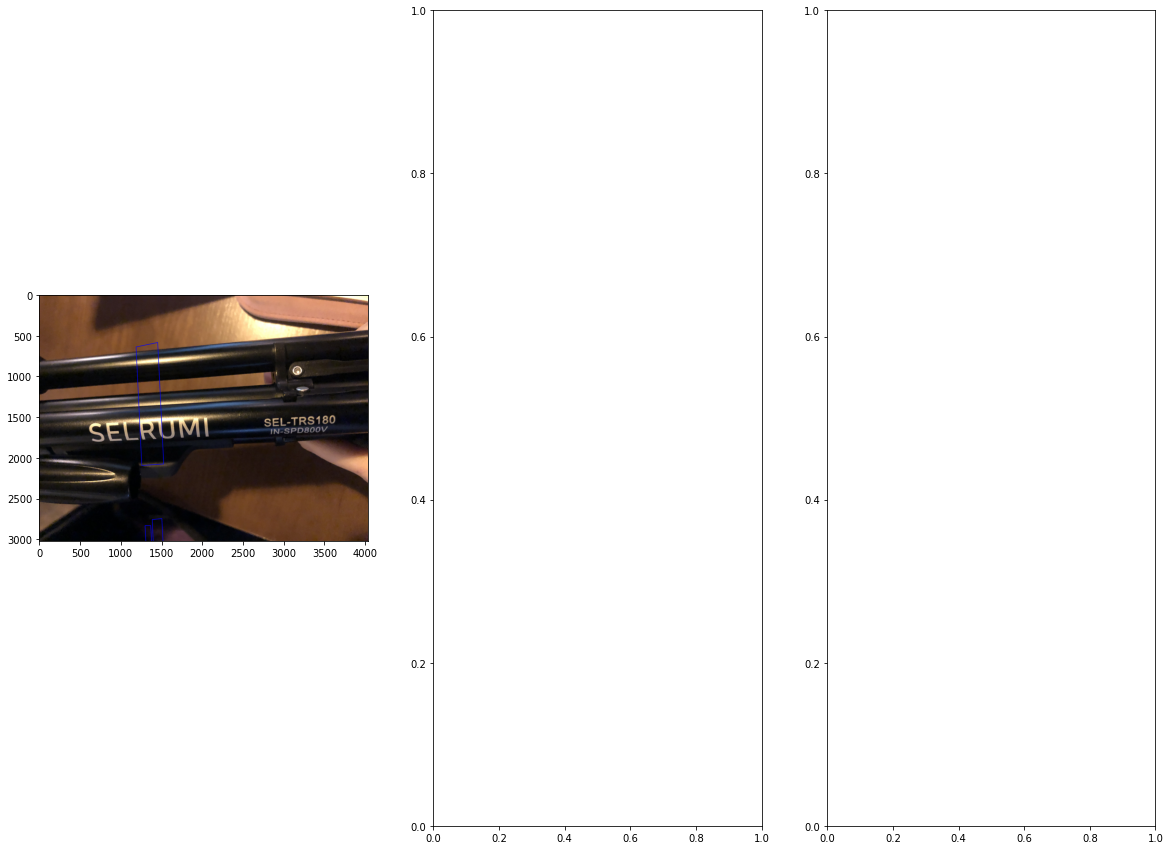

In [23]:
SAMPLE_IDX =9
image_id = image_ids[SAMPLE_IDX]
image_path = os.path.join(DATASET_DIR, 'images', image_id)
image = np.array(Image.open(image_path))

print('Image:\t{}'.format(image.shape))

bboxes, labels = [], []
for word_info in train_json['images'][image_id]['words'].values():
    bboxes.append(np.array(word_info['points']))
    labels.append(int(not word_info['illegibility']))
bboxes, labels = np.array(bboxes, dtype=np.float32), np.array(labels, dtype=np.float32)

print('Bboxes:\t{}'.format(bboxes.shape))
print('Labels:\t{}'.format(labels.shape))
alb_transform = A.Compose([
    # A.RandomScale(p=1.0, scale_limit=0.5),
    # A.Rotate(p=1.0, limit=90, border_mode=cv2.BORDER_CONSTANT),
    # A.HorizontalFlip(), A.VerticalFlip(),
    # A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    A.ColorJitter(0.5, 0.5, 0.5, 0.25),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.15, p=1),
    A.GaussNoise(p=1),
    A.CLAHE(p=1),
    A.OpticalDistortion(distort_limit=0.1, p=1.0),
    #A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

FIG_SIZE = (5, 5)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 15))

bboxes_voc = []
for bbox in bboxes:
    x0, y0 = bbox.min(axis=0).astype(np.int64)
    x1, y1 = bbox.max(axis=0).astype(np.int64)
    bboxes_voc.append([x0, y0, x1, y1])
draw_bboxes(img=image, bboxes=bboxes, labels=labels, thickness=5)
axs[0].imshow(image)
# axs[1].imshow(alb_transform(image=image)['image'])
# axs[2].imshow(alb_transform(image=image)['image'])

In [7]:
alb_transform = A.Compose([
    #A.Rotate(p=1.0, limit=90),
    A.Resize(height=1024, width=1024),
    A.RandomResizedCrop(height=512, width=512, scale=(0.5, 1.0), p=1),
    A.Rotate(p=1.0, limit=90),
    A.ColorJitter(0.5, 0.5, 0.5, 0.25, p=1),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.15, p=1),
    A.GaussNoise(p=1),
    A.CLAHE(p=1),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

bboxes_voc = []
for bbox in bboxes:
    x0, y0 = bbox.min(axis=0).astype(np.int64)
    x1, y1 = bbox.max(axis=0).astype(np.int64)
    bboxes_voc.append([x0, y0, x1, y1])

transformed = alb_transform(image=image, bboxes=bboxes_voc, class_labels=labels)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 10))
vis = image.copy()
draw_bboxes(img=vis, bboxes=bboxes, labels=labels, thickness=5)
axs[0].imshow(vis)
axs[0].set_title('Original', fontsize=18)
vis = transformed['image']
new_labels = transformed['class_labels']
bboxes_transformed = np.array([
    [[x0, y0], [x1, y0], [x1, y1], [x0, y1]] for x0, y0, x1, y1 in transformed['bboxes']]
    , dtype=np.float32)
draw_bboxes(img=vis, bboxes=bboxes_transformed, labels=labels, thickness=5)
axs[1].imshow(vis)
axs[1].set_title('Transformed', fontsize=18)

ValueError: Expected y_max for bbox (0.283203125, 0.89453125, 0.447265625, 1.015625, 1.0) to be in the range [0.0, 1.0], got 1.015625.

In [74]:
vertices = []
bboxes = []
for word_info in train_json['images'][image_id]['words'].values():
    vertices.append(np.array(word_info['points']).flatten())
    bboxes.append(np.array(word_info['points']))
vertices = np.array(vertices)
bboxes = np.array(bboxes)